## random reference
## random constraint
## only tracking (no constraint)

In [61]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


# read data

In [62]:
import pandas as pd
import numpy as np
import copy
from collections import defaultdict

# ── Load and clean ────────────────────────────────
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
df_all = df_all.dropna()

# ── Round Z to nearest 0.75 to define Z groups ─────
df_all['Z_group'] = np.floor(df_all['Z'] / 0.75) * 0.75
df_all = df_all[df_all['Z_group'] > 0.0]
unique_groups = sorted(df_all['Z_group'].unique())
print("Z groups (0.75-step):", unique_groups)

# ── Container for grouped data ─────────────────────
layer_data = defaultdict(dict)

for z_group in unique_groups:
    df_z = df_all[df_all["Z_group"] == z_group]

    loc_X = df_z["X"].to_numpy().reshape(-1,1)
    loc_Y = df_z["Y"].to_numpy().reshape(-1,1)
    loc_Z = df_z["Z"].to_numpy().reshape(-1,1)
    dist_X = df_z["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
    dist_Y = df_z["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
    scan_spd = df_z["scanning_speed"].to_numpy().reshape(-1,1)
    laser_power = df_z["Laser_power"].to_numpy().reshape(-1,1)
    laser_on_off = df_z["laser_power_number"].to_numpy().reshape(-1,1)

    # melt pool temp (moving average)
    mp_temp_raw = df_z["melt_pool_temperature"].to_numpy()
    mp_temp_mv = moving_average_1d(mp_temp_raw, 4)
    mp_temp = copy.deepcopy(mp_temp_raw)
    mp_temp[1:-2] = mp_temp_mv
    mp_temp = mp_temp.reshape(-1,1)

    # melt pool depth (moving average)
    mp_depth_raw = df_z["melt_pool_depth"].to_numpy()
    mp_depth_mv = moving_average_1d(mp_depth_raw, 4)
    mp_depth = copy.deepcopy(mp_depth_raw)
    mp_depth[1:-2] = mp_depth_mv
    mp_depth = mp_depth.reshape(-1,1)

    # Store everything
    layer_data[z_group]["X"] = loc_X
    layer_data[z_group]["Y"] = loc_Y
    layer_data[z_group]["Z"] = loc_Z
    layer_data[z_group]["Dist_X"] = dist_X
    layer_data[z_group]["Dist_Y"] = dist_Y
    layer_data[z_group]["Scan_Speed"] = scan_spd
    layer_data[z_group]["Laser_Power"] = laser_power
    layer_data[z_group]["Laser_On_Off"] = laser_on_off
    layer_data[z_group]["MP_Temp"] = mp_temp
    layer_data[z_group]["MP_Depth"] = mp_depth

    print(f"✅ Z group {z_group:.2f} → shape={mp_temp.shape}")


Z groups (0.75-step): [np.float64(0.75), np.float64(1.5), np.float64(2.25), np.float64(3.0), np.float64(3.75), np.float64(4.5), np.float64(5.25), np.float64(6.0), np.float64(6.75), np.float64(7.5)]
✅ Z group 0.75 → shape=(59364, 1)
✅ Z group 1.50 → shape=(59073, 1)
✅ Z group 2.25 → shape=(59170, 1)
✅ Z group 3.00 → shape=(59073, 1)
✅ Z group 3.75 → shape=(59073, 1)
✅ Z group 4.50 → shape=(59170, 1)
✅ Z group 5.25 → shape=(59073, 1)
✅ Z group 6.00 → shape=(59073, 1)
✅ Z group 6.75 → shape=(59170, 1)
✅ Z group 7.50 → shape=(78085, 1)


## normalize

In [63]:
group_scalers = {}

for z in unique_groups:
    data = layer_data[z]

    x = np.concatenate((data["Z"], data["Dist_X"], data["Dist_Y"], data["Laser_Power"]), axis=1)
    y = np.concatenate((data["MP_Temp"], data["MP_Depth"]), axis=1)

    x_max = np.max(x, axis=0, keepdims=True)
    x_min = np.min(x, axis=0, keepdims=True)
    y_max = np.max(y, axis=0, keepdims=True)
    y_min = np.min(y, axis=0, keepdims=True)

    x_norm = (x - x_min) / (x_max - x_min + 1e-8)
    y_norm = (y - y_min) / (y_max - y_min + 1e-8)

    layer_data[z]["x_norm"] = x_norm
    layer_data[z]["y_norm"] = y_norm

    group_scalers[z] = {
        "x_max": x_max,
        "x_min": x_min,
        "y_max": y_max,
        "y_min": y_min
    }

    print(f"✅ Z={z:.2f} | x_norm shape={x_norm.shape} | y_norm shape={y_norm.shape}")


✅ Z=0.75 | x_norm shape=(59364, 4) | y_norm shape=(59364, 2)
✅ Z=1.50 | x_norm shape=(59073, 4) | y_norm shape=(59073, 2)
✅ Z=2.25 | x_norm shape=(59170, 4) | y_norm shape=(59170, 2)
✅ Z=3.00 | x_norm shape=(59073, 4) | y_norm shape=(59073, 2)
✅ Z=3.75 | x_norm shape=(59073, 4) | y_norm shape=(59073, 2)
✅ Z=4.50 | x_norm shape=(59170, 4) | y_norm shape=(59170, 2)
✅ Z=5.25 | x_norm shape=(59073, 4) | y_norm shape=(59073, 2)
✅ Z=6.00 | x_norm shape=(59073, 4) | y_norm shape=(59073, 2)
✅ Z=6.75 | x_norm shape=(59170, 4) | y_norm shape=(59170, 2)
✅ Z=7.50 | x_norm shape=(78085, 4) | y_norm shape=(78085, 2)


In [64]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [65]:
group_scalers = {}

for z in unique_groups:
    data = layer_data[z]

    x_original = np.concatenate((data["Z"], data["Dist_X"], data["Dist_Y"], data["Laser_Power"]), axis=1)
    y_original = np.concatenate((data["MP_Temp"], data["MP_Depth"]), axis=1)

    x_max = np.max(x_original, axis=0, keepdims=True)
    x_min = np.min(x_original, axis=0, keepdims=True)
    y_max = np.max(y_original, axis=0, keepdims=True)
    y_min = np.min(y_original, axis=0, keepdims=True)

    group_scalers[z] = scalers(x_max, x_min, y_max, y_min)

    x_s = group_scalers[z].scaler_x(x_original)
    y_s = group_scalers[z].scaler_y(y_original)

    layer_data[z]["x_s"] = x_s
    layer_data[z]["y_s"] = y_s

    print(f"✅ Z={z:.2f} | x_s shape={x_s.shape}, y_s shape={y_s.shape}, x_s range: {x_s.min():.2f} to {x_s.max():.2f}, y_s range: {y_s.min():.2f} to {y_s.max():.2f}")


✅ Z=0.75 | x_s shape=(59364, 4), y_s shape=(59364, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=1.50 | x_s shape=(59073, 4), y_s shape=(59073, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=2.25 | x_s shape=(59170, 4), y_s shape=(59170, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=3.00 | x_s shape=(59073, 4), y_s shape=(59073, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=3.75 | x_s shape=(59073, 4), y_s shape=(59073, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=4.50 | x_s shape=(59170, 4), y_s shape=(59170, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=5.25 | x_s shape=(59073, 4), y_s shape=(59073, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=6.00 | x_s shape=(59073, 4), y_s shape=(59073, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=6.75 | x_s shape=(59170, 4), y_s shape=(59170, 2), x_s range: -1.00 to 1.00, y_s range: -1.00 to 1.00
✅ Z=7.50 | x_s shape=(78085, 4), y_s shape=(78

## generate data

In [66]:
for z in unique_groups:
    x_s = layer_data[z]["x_s"] if "x_s" in layer_data[z] else layer_data[z]["x_scaled"]
    y_s = layer_data[z]["y_s"] if "y_s" in layer_data[z] else layer_data[z]["y_scaled"]
    
    length = y_s.shape[0]

    # Reference target temperature (for tracking)
    y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

    # Constraints (depth bounds in normalized space)
    e = 0.0001
    y_depth_low = 0 * np.random.uniform(0.1423 - e, 0.1423 + e, size=(length, 1))
    y_depth_up = 0 * np.random.uniform(0.4126 - e, 0.4126 + e, size=(length, 1))
    y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

    # Store in layer_data
    layer_data[z]["y_ref"] = y_s_ref
    layer_data[z]["y_const"] = y_s_const

    print(f"✅ Z={z:.2f} | y_ref shape={y_s_ref.shape}, y_const shape={y_s_const.shape}")


✅ Z=0.75 | y_ref shape=(59364, 1), y_const shape=(59364, 2)
✅ Z=1.50 | y_ref shape=(59073, 1), y_const shape=(59073, 2)
✅ Z=2.25 | y_ref shape=(59170, 1), y_const shape=(59170, 2)
✅ Z=3.00 | y_ref shape=(59073, 1), y_const shape=(59073, 2)
✅ Z=3.75 | y_ref shape=(59073, 1), y_const shape=(59073, 2)
✅ Z=4.50 | y_ref shape=(59170, 1), y_const shape=(59170, 2)
✅ Z=5.25 | y_ref shape=(59073, 1), y_const shape=(59073, 2)
✅ Z=6.00 | y_ref shape=(59073, 1), y_const shape=(59073, 2)
✅ Z=6.75 | y_ref shape=(59170, 1), y_const shape=(59170, 2)
✅ Z=7.50 | y_ref shape=(78085, 1), y_const shape=(78085, 2)


## split data

In [67]:
from tqdm import tqdm
import torch

window = 50
P = 50

split_data_by_group = {}

for z in unique_groups:
    x_s = layer_data[z]["x_s"]
    y_s = layer_data[z]["y_s"]
    y_s_const = layer_data[z]["y_const"]

    cutoff_index = int(np.round(0.9 * x_s.shape[0]))
    x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
    x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
    y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

    # Training
    n_train = cutoff_index - P - window
    x_past_train = np.empty((n_train, window, 4))
    y_past_train = np.empty((n_train, window, 2))
    x_future_train = np.empty((n_train, P, 3))
    y_ref_train_seq = np.empty((n_train, P, 1))
    y_const_train_seq = np.empty((n_train, P, 2))

    for i in range(window, cutoff_index - P):
        j = i - window
        x_past_train[j] = x_train[i-window:i]
        y_past_train[j] = y_train[i-window:i]
        x_future_train[j] = x_train[i:i+P, :3]
        scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
        y_ref_train_seq[j] = y_train[i:i+P, :1] + scalar_shift
        y_const_train_seq[j] = y_const_train[i:i+P]

    # Validation
    val_cutoff = x_s.shape[0] - cutoff_index
    n_val = val_cutoff - P - window
    x_past_val = np.empty((n_val, window, 4))
    y_past_val = np.empty((n_val, window, 2))
    x_future_val = np.empty((n_val, P, 3))
    y_ref_val_seq = np.empty((n_val, P, 1))
    y_const_val_seq = np.empty((n_val, P, 2))

    for i in range(window, val_cutoff - P):
        j = i - window
        x_past_val[j] = x_val[i-window:i]
        y_past_val[j] = y_val[i-window:i]
        x_future_val[j] = x_val[i:i+P, :3]
        scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
        y_ref_val_seq[j] = y_val[i:i+P, :1] + scalar_shift
        y_const_val_seq[j] = y_const_val[i:i+P]

    # Tensor conversion
    data_dict = {
        "x_past_train": torch.tensor(x_past_train, dtype=torch.float32),
        "y_past_train": torch.tensor(y_past_train, dtype=torch.float32),
        "x_future_train": torch.tensor(x_future_train, dtype=torch.float32),
        "y_ref_train_seq": torch.tensor(y_ref_train_seq, dtype=torch.float32),
        "y_const_train_seq": torch.tensor(y_const_train_seq, dtype=torch.float32),

        "x_past_val": torch.tensor(x_past_val, dtype=torch.float32),
        "y_past_val": torch.tensor(y_past_val, dtype=torch.float32),
        "x_future_val": torch.tensor(x_future_val, dtype=torch.float32),
        "y_ref_val_seq": torch.tensor(y_ref_val_seq, dtype=torch.float32),
        "y_const_val_seq": torch.tensor(y_const_val_seq, dtype=torch.float32),
    }

    split_data_by_group[z] = data_dict

    print(f"✅ Z={z:.2f} split: train {n_train}, val {n_val}")


✅ Z=0.75 split: train 53328, val 5836
✅ Z=1.50 split: train 53066, val 5807
✅ Z=2.25 split: train 53153, val 5817
✅ Z=3.00 split: train 53066, val 5807
✅ Z=3.75 split: train 53066, val 5807
✅ Z=4.50 split: train 53153, val 5817
✅ Z=5.25 split: train 53066, val 5807
✅ Z=6.00 split: train 53066, val 5807
✅ Z=6.75 split: train 53153, val 5817
✅ Z=7.50 split: train 70176, val 7709


In [68]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128
group_loaders = {}

for z in unique_groups:
    data = split_data_by_group[z]

    # 가져오기
    x_past_train = data["x_past_train"]
    y_past_train = data["y_past_train"]
    x_future_train = data["x_future_train"]
    y_ref_train_seq = data["y_ref_train_seq"]
    y_const_train_seq = data["y_const_train_seq"]

    x_past_val = data["x_past_val"]
    y_past_val = data["y_past_val"]
    x_future_val = data["x_future_val"]
    y_ref_val_seq = data["y_ref_val_seq"]
    y_const_val_seq = data["y_const_val_seq"]

    # TensorDataset 생성
    train_dataset = TensorDataset(x_past_train, y_past_train, x_future_train, y_ref_train_seq, y_const_train_seq)
    val_dataset = TensorDataset(x_past_val, y_past_val, x_future_val, y_ref_val_seq, y_const_val_seq)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    group_loaders[z] = {
        "train": train_loader,
        "val": val_loader
    }

    print(f"✅ Z={z:.2f} → train batches={len(train_loader)}, val batches={len(val_loader)}")


✅ Z=0.75 → train batches=417, val batches=46
✅ Z=1.50 → train batches=415, val batches=46
✅ Z=2.25 → train batches=416, val batches=46
✅ Z=3.00 → train batches=415, val batches=46
✅ Z=3.75 → train batches=415, val batches=46
✅ Z=4.50 → train batches=416, val batches=46
✅ Z=5.25 → train batches=415, val batches=46
✅ Z=6.00 → train batches=415, val batches=46
✅ Z=6.75 → train batches=416, val batches=46
✅ Z=7.50 → train batches=549, val batches=61


# loss function


In [69]:
def DPC_loss(x_past: torch.Tensor, tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor,
             w_tracking=1.0, w_smooth=0, w_constraint=0):
    
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]
    reference = reference[:, :, 0]
    tracking_loss = (reference - tide_output_temp) ** 2

    # ─── Apply time-dependent Q weights (linearly decreasing) ───
    T = tracking_loss.shape[1]
    q_weights = torch.linspace(1.0, 1.0, T, device=tracking_loss.device)  # shape [T]
    q_weights = q_weights.unsqueeze(0)  # shape [1, T] for broadcasting
    tracking_loss = tracking_loss * q_weights  # shape [B, T]


    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    #u_diff_2 = x_past[:, -1, 3] - u_output[:,   0, :] ## added for smoothness loss
    smoothness_loss = u_diff ** 2 
    #smoothness_loss_2 = (1/50) * u_diff_2 ** 2

    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = 0 * low_violation + up_violation

    L_tracking = torch.sqrt(tracking_loss.mean())
    L_smooth = torch.sqrt(smoothness_loss.mean()) #+ torch.sqrt(smoothness_loss_2.mean())
    L_constraint = torch.sqrt(constraint_loss.mean())

    loss = (
        w_tracking * L_tracking +
        w_smooth * L_smooth +
        w_constraint * L_constraint
    )

    return loss, L_tracking.item(), L_smooth.item(), L_constraint.item()


In [70]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())

In [71]:
import pickle
import os

def train_and_evaluate(n_layers, hidden_dim, setting_name,
                       w_smooth, w_constraint, train_loader, val_loader):
    model = PolicyNN(
        past_input_dim=6,
        future_input_dim=6,
        output_dim=1,
        p=50,
        window=50,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout_p=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    counter = 0

    with tqdm(total=num_epoch, desc=setting_name) as pbar:
        model.train()

        save_train_tracking = np.zeros(num_epoch)
        save_train_smooth = np.zeros(num_epoch)
        save_train_constraint = np.zeros(num_epoch)

        save_val_tracking = np.zeros(num_epoch)
        save_val_smooth = np.zeros(num_epoch)
        save_val_constraint = np.zeros(num_epoch)

        for epoch in range(num_epoch):

            for x_past, y_past, x_future, y_ref, y_const in train_loader:
                x_past, y_past, x_future, y_ref, y_const = (
                    x_past.to(device), y_past.to(device),
                    x_future.to(device), y_ref.to(device), y_const.to(device)
                )

                policy_in_past = torch.cat((x_past, y_past), dim=2)
                policy_in_future = torch.cat((x_future, y_ref, y_const), dim=2)

                optimizer.zero_grad()

                u_output = model((policy_in_past, policy_in_future))
                x_future_tide = torch.cat((x_future, u_output), dim=2)
                past_cov = torch.cat((y_past, x_past), dim=2)

                tide_pred = TiDE((past_cov, x_future_tide, None))
                loss, l_track, l_smooth, l_const = DPC_loss(x_past, tide_pred, y_ref, u_output, y_const,
                                w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                loss.backward()
                optimizer.step()

            # validation
            model.eval()
            val_loss_total = 0.0
            val_track_total = 0.0
            val_smooth_total = 0.0
            val_const_total = 0.0
            num_val_batches = 0


            with torch.no_grad():
                for val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const in val_loader:
                    val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const = (
                        val_x_past.to(device), val_y_past.to(device),
                        val_x_future.to(device), val_y_ref.to(device), val_y_const.to(device)
                    )

                    val_policy_in_past = torch.cat((val_x_past, val_y_past), dim=2)
                    val_policy_in_fut = torch.cat((val_x_future, val_y_ref, val_y_const), dim=2)

                    val_u_output = model((val_policy_in_past, val_policy_in_fut))

                    x_future_tide_val = torch.cat((val_x_future, val_u_output), dim=2)
                    past_cov_val = torch.cat((val_y_past, val_x_past), dim=2)

                    val_tide_pred = TiDE((past_cov_val, x_future_tide_val, None))
                    val_loss, val_l_track, val_l_smooth, val_l_const = DPC_loss(val_x_past, val_tide_pred, val_y_ref, val_u_output, val_y_const,
                                        w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                    val_loss_total += val_loss.item()
                    val_track_total += val_l_track
                    val_smooth_total += val_l_smooth
                    val_const_total += val_l_const
                    num_val_batches += 1

            val_loss_avg = val_loss_total / num_val_batches
            val_track_avg = val_track_total / num_val_batches
            val_smooth_avg = val_smooth_total / num_val_batches
            val_const_avg = val_const_total / num_val_batches

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss_avg

            save_train_tracking[epoch] = l_track
            save_train_smooth[epoch] = l_smooth
            save_train_constraint[epoch] = l_const

            save_val_tracking[epoch] = val_track_avg
            save_val_smooth[epoch] = val_smooth_avg
            save_val_constraint[epoch] = val_const_avg

            scheduler.step()
            pbar.set_description(
                f"{setting_name} | Epoch {epoch} "
                f"| Train: {loss.item():.4f} (t={l_track:.3f}, s={l_smooth:.3f}, c={l_const:.3f}) "
                f"| Val: {val_loss_avg:.4f} (t={val_track_avg:.3f}, s={val_smooth_avg:.3f}, c={val_const_avg:.3f})"
            )
            pbar.update(1)


    # directory where you want to store all results
    train_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # build filename and full path
    model_filename = f"policy_model_{setting_name}.pth"
    model_path = os.path.join(train_dir, model_filename)

    # save and report
    torch.save(best_model, model_path)
    print(f"Saved model to: {model_path}")

    # Save model parameters as .pkl
    model_params = {
        "model_name": setting_name,
        "past_input_dim": 6,
        "future_input_dim": 6,
        "output_dim": 1,
        "future_cov_dim": 2,
        "static_cov_dim": 0,
        "window": 50,
        "p": 50,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epoch": num_epoch,
        "w_smooth": w_smooth,
        "w_constraint": w_constraint
    }

    train_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # save model parameters
    param_filename = f"policy_parameters_{setting_name}.pkl"
    param_path = os.path.join(train_dir, param_filename)
    with open(param_path, "wb") as f:
        pickle.dump(model_params, f)
    print(f"Saved model parameters to: {param_path}")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss,
        "train_tracking_loss": save_train_tracking,
        "train_smooth_loss": save_train_smooth,
        "train_constraint_loss": save_train_constraint,
        "val_tracking_loss": save_val_tracking,
        "val_smooth_loss": save_val_smooth,
        "val_constraint_loss": save_val_constraint
    }


In [ ]:
# Hyperparameters
num_epoch = 20
learning_rate = 1e-3
weight_decay = 1e-5
patience = 100

w_smooth = 0
w_constraint = 0

# ─── Loop over Z-layers and call training ──────────────────────
for z_key, loader_dict in group_loaders.items():
    train_loader = loader_dict["train"]
    val_loader = loader_dict["val"]

    setting_name = f"z{z_key:.2f}_s{w_smooth}_c{w_constraint}"

    print(f"\n=== Training for Z = {z_key:.2f} ===")
    results = train_and_evaluate(
        n_layers=3,
        hidden_dim=1024,
        setting_name=setting_name,
        w_smooth=w_smooth,
        w_constraint=w_constraint,
        train_loader=train_loader,
        val_loader=val_loader
    )

    # Save per-layer result log
    result_path = f"/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/trainlog_{setting_name}.pkl"
    with open(result_path, 'wb') as f:
        pickle.dump(results, f)

    print(f"📁 Saved training logs to {result_path}")



=== Training for Z = 0.75 ===


z0.75_s0_c0:   0%|          | 0/20 [00:00<?, ?it/s]

z0.75_s0_c0 | Epoch 2 | Train: 0.1696 (t=0.170, s=9.018, c=0.011) | Val: 0.1318 (t=0.132, s=8.618, c=0.003):  15%|█▌        | 3/20 [00:13<01:13,  4.35s/it]

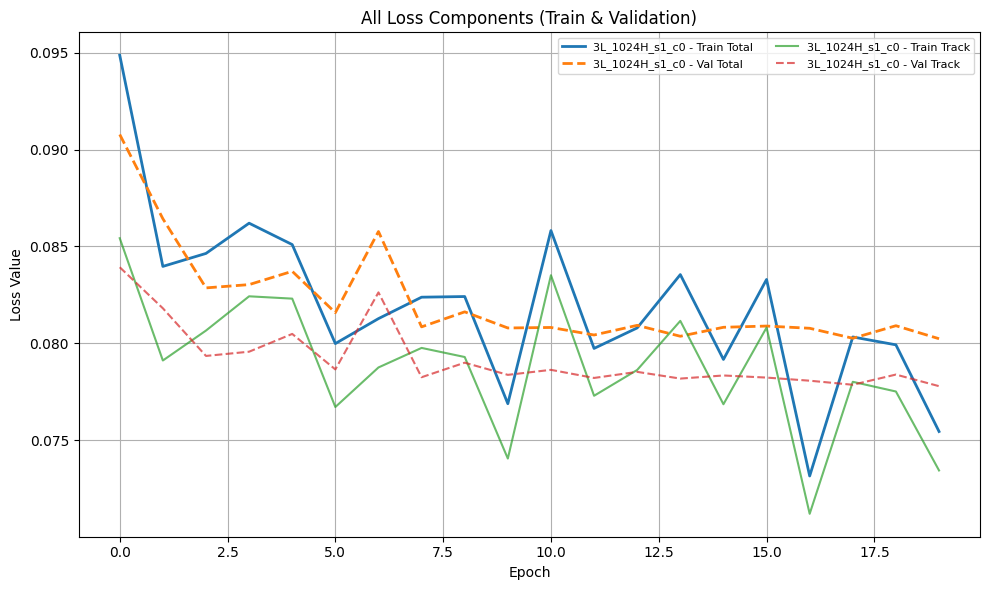

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for setting_name, result in results.items():
    # Total loss
    plt.plot(result['train_loss'], label=f"{setting_name} - Train Total", linewidth=2)
    plt.plot(result['val_loss'], label=f"{setting_name} - Val Total", linestyle='--', linewidth=2)

    # Tracking loss
    plt.plot(result['train_tracking_loss'], label=f"{setting_name} - Train Track", alpha=0.7)
    plt.plot(result['val_tracking_loss'], label=f"{setting_name} - Val Track", linestyle='--', alpha=0.7)

    # Smoothness loss
    #plt.plot(result['train_smooth_loss'], label=f"{setting_name} - Train Smooth", alpha=0.7)
    #plt.plot(result['val_smooth_loss'], label=f"{setting_name} - Val Smooth", linestyle='--', alpha=0.7)

    # Constraint loss
    #plt.plot(result['train_constraint_loss'], label=f"{setting_name} - Train Const", alpha=0.7)
    #plt.plot(result['val_constraint_loss'], label=f"{setting_name} - Val Const", linestyle='--', alpha=0.7)

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("All Loss Components (Train & Validation)")
plt.legend(loc="upper right", fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
